# 3-D Exodus example

Anthony Gruber 3-31-2023

In [1]:
# Imports for exodus
import sys
sys.path.append('/Users/adgrube/Desktop/Code/seacas/lib')  ### replace with your Seacas installation
import exodus

# Standard imports
import numpy as np
# from scipy.linalg import svd
from scipy.sparse import eye, csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import mmread, loadmat
import matplotlib.pyplot as plt

# Import for utils
sys.path.append("..")

import OpInf_utils as ou
import ROM_utils as ru

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

# Creating exodus file
fromFileName = 'beam_velIC_100.e'
toFileName   = 'beam_vecIC_100_written.e'

massName  = 'mass.mm'
stiffName = 'stiff.mm'

ROMvariables = ['exactSol_x', 'exactSol_y', 'exactSol_z',
                '1-disp_G-OpRom_x', '1-disp_G-OpRom_y', '1-disp_G-OpRom_z',
                '1-disp_NC-H-OpRom_x', '1-disp_NC-H-OpRom_y', '1-disp_NC-H-OpRom_z',
                '1-disp_C-H-OpRom_x', '1-disp_C-H-OpRom_y', '1-disp_C-H-OpRom_z',
                '1-disp_G-IntRom_x', '1-disp_G-IntRom_y', '1-disp_G-IntRom_z',
                '1-disp_H-IntRom_x', '1-disp_H-IntRom_y', '1-disp_H-IntRom_z',
                '2-disp_G-OpRom_x', '2-disp_G-OpRom_y', '2-disp_G-OpRom_z',
                '2-disp_NC-H-OpRom_x', '2-disp_NC-H-OpRom_y', '2-disp_NC-H-OpRom_z',
                '2-disp_C-H-OpRom_x', '2-disp_C-H-OpRom_y', '2-disp_C-H-OpRom_z',
                '2-disp_G-IntRom_x', '2-disp_G-IntRom_y', '2-disp_G-IntRom_z',
                '2-disp_H-IntRom_x', '2-disp_H-IntRom_y', '2-disp_H-IntRom_z',
                '3-disp_G-OpRom_x', '3-disp_G-OpRom_y', '3-disp_G-OpRom_z',
                '3-disp_NC-H-OpRom_x', '3-disp_NC-H-OpRom_y', '3-disp_NC-H-OpRom_z',
                '3-disp_C-H-OpRom_x', '3-disp_C-H-OpRom_y', '3-disp_C-H-OpRom_z',
                '3-disp_G-IntRom_x', '3-disp_G-IntRom_y', '3-disp_G-IntRom_z',
                '3-disp_H-IntRom_x', '3-disp_H-IntRom_y', '3-disp_H-IntRom_z']

# # # Use this the first time the file is created
# exo_copy = exodus.copyTransfer(fromFileName, toFileName,
#                                array_type='numpy',
#                                additionalNodalVariables=ROMvariables)

# Use this after file is created
exo_copy = exodus.exodus(f'{fromFileName}', array_type='numpy')


You are using exodus.py v 1.20.17 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013-2022 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: beam_velIC_100.e


### Function which grabs snapshots from Irina's data and assembles FOM quantities

In [2]:
# Function which grabs everything from the exodus file
# The snapshots are kind of weird -- energy drops after first iteration

def assemble_FOM(exo_file):
    # Import mass and stiffness matrices
    N     = exo_file.num_nodes()
    Nt    = exo_file.num_times()
    mass  = mmread(massName)
    stiff = mmread(stiffName)

    # stiff = 0.5 * (stiff+stiff.T)
    # mass  = 0.5 * (mass+mass.T)
    M = mass.todense()
    K = stiff.todense()

    # Solution arrays ordered by node_id
    sol_x   = np.zeros((N, Nt))
    sol_y   = np.zeros((N, Nt))
    sol_z   = np.zeros((N, Nt))

    # for position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('disp_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('disp_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('disp_z', t+1)

    # Full position array (interleaved like M, K matrices)
    q_arr       = np.zeros((3*N, Nt))
    q_arr[0::3] = sol_x
    q_arr[1::3] = sol_y
    q_arr[2::3] = sol_z

    # for derivative of position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dot_z', t+1)

    # Full qDot array
    qDot_arr       = np.zeros((3*N, Nt))
    qDot_arr[0::3] = sol_x
    qDot_arr[1::3] = sol_y
    qDot_arr[2::3] = sol_z

    # for derivative of momentum
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dotdot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dotdot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dotdot_z', t+1)

    # Full pDot array
    qDotDot_arr       = np.zeros((3*N, Nt))
    qDotDot_arr[0::3] = sol_x
    qDotDot_arr[1::3] = sol_y
    qDotDot_arr[2::3] = sol_z

    return (q_arr, qDot_arr, qDotDot_arr), M, K


## Computing the FOM solution in Hamiltonian form and building POD basis

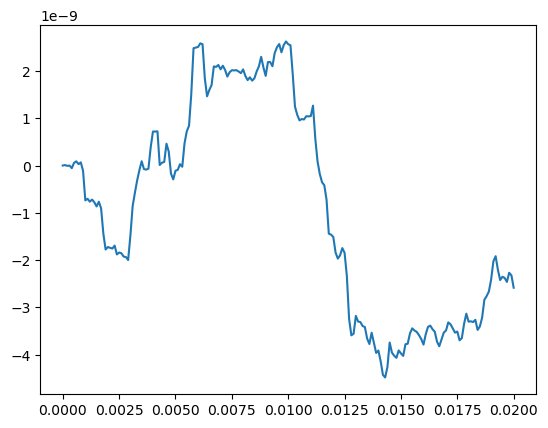

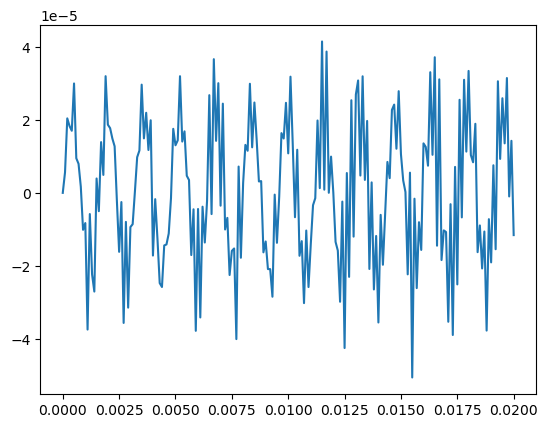

In [3]:
# Get data from exodus file (201 snaps)
data, M, K = assemble_FOM(exo_copy)

# Doing the integration (takes about 2:40)
tTrain = np.linspace(0, 0.02, 201)
pFunc  = lambda x: np.zeros_like(data[0][:,0])
ics = (data[0][:,0], data[1][:,0], data[2][:,0])
data  = ru.integrate_LFOM(tTrain, ics, M, np.zeros_like(M), K, pFunc)

MM = csc_matrix(M)
KK = csc_matrix(K)
H  = np.zeros_like(tTrain)

for i in range(len(tTrain)):
    H1 = data[1][:,i] @ MM @ data[1][:,i]
    H2 = data[0][:,i] @ KK @ data[0][:,i]
    H[i] = 0.5*(H1+H2)

plt.plot(tTrain, H-H[0])
plt.show()

plt.plot(tTrain, data[0][10,:])

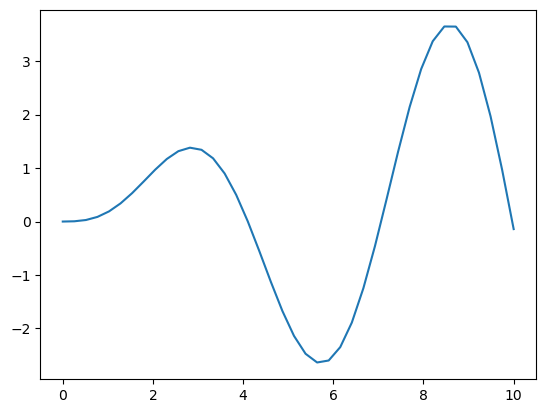

In [8]:
M = csc_matrix(np.diag([1,1]))
K = csc_matrix([[1+10**7,-1],[-1,1]])
pfunc = lambda t: np.array([10**7 * np.sin(1.2*t), 0])

tTrain = np.linspace(0, 10, 40)
ics = (np.zeros(2), np.zeros(2), np.zeros(2))
data2  = ru.integrate_LFOM(tTrain, ics, M, np.zeros_like(M.todense()), K, pfunc)

plt.plot(tTrain, data2[0][1])

In [8]:
from importlib import reload
reload(ru)

romclass = ru.Linear_Lagrangian_ROM(data[0])

romclass.set_reduced_basis('POD', centered=True)
romclass.assemble_Hamiltonian_from_Lagrangian_ROM(40, MM, KK, data[1])
romclass.integrate_Hamiltonian_from_Lagrangian_ROM(tTrain)
qrecon = romclass.decode(romclass.q_hat)

romclass.assemble_Lagrangian_ROM(40, MM, KK, data[1], data[2])
romclass.integrate_Lagrangian_ROM(tTrain)
qrecon = romclass.decode(romclass.q_hat)

ru.relError(data[0], qrecon)

0.00013693005500054633

## Computing POD bases and snapshot plots

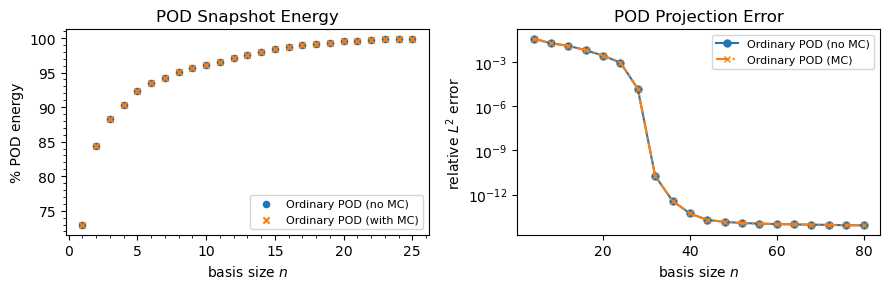

In [9]:
X = data[0]
# Xmc = X - X[:,0].reshape(-1,1)
Nt = X.shape[1]

# ## Ordinary POD algo
# UU, SS     = np.linalg.svd(X[:,:Nt])[:2]
# UUmc, SSmc = np.linalg.svd(Xmc[:,:Nt])[:2]

romclass = ru.Linear_Lagrangian_ROM(X)
romclass.set_reduced_basis('POD', centered=False)
UU = romclass.reduced_basis
SS = romclass.basis_evals
romclass.set_reduced_basis('POD', centered=True)
UUmc = romclass.reduced_basis
SSmc = romclass.basis_evals

nEigs = 25
idx = [i+1 for i in range(nEigs)]
X1  = X[:,:Nt]
ic  = X[:,0].reshape(-1,1)

name = "tab10"
cmap = plt.get_cmap(name)

nList  = [4*(i+1) for i in range(20)]
errU   = np.zeros(len(nList))
errUmc = np.zeros(len(nList))

for i,n in enumerate(nList):
    Umc   = UUmc[:,:n]
    U     = UU[:,:n]

    reconUmc  = ic.reshape(-1,1) + Umc @ Umc.T @ (X1 - ic.reshape(-1,1))
    reconU    = U @ U.T @ X1

    errUmc[i] = ru.relError(X1, reconUmc)
    errU[i]   = ru.relError(X1, reconU)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, np.cumsum(SS[:nEigs] / np.sum(SS))*100, s=20., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SSmc[:nEigs] / np.sum(SSmc))*100, s=20., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[1])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('solidmechPODenergy', transparent=True)
plt.show()

the relative L2 errors for intrusive GROM are [5.91944010e-01 4.29466055e-01 1.02423705e-01 3.51419135e-02
 9.81720560e-03 8.28902930e-03 3.40354773e-04 2.23059153e-04
 1.90757543e-04 1.36930055e-04 1.27870381e-04 9.18529996e-05
 8.66140465e-05 8.19435413e-05 7.61501767e-05 7.51042518e-05
 7.06689035e-05 6.69495732e-05 6.61929564e-05 6.49004641e-05
 6.49999213e-05 6.47798774e-05 6.45207579e-05 6.36639877e-05
 6.33683738e-05]
the relative L2 errors for intrusive GROM (mean centering) are [5.91944010e-01 4.29466055e-01 1.02423705e-01 3.51419135e-02
 9.81720560e-03 8.28902930e-03 3.40354773e-04 2.23059153e-04
 1.90757543e-04 1.36930055e-04 1.27870381e-04 9.18529996e-05
 8.66140465e-05 8.19435413e-05 7.61501767e-05 7.51042518e-05
 7.06689035e-05 6.69495732e-05 6.61929564e-05 6.49004641e-05
 6.49999213e-05 6.47798774e-05 6.45207579e-05 6.36639877e-05
 6.33683738e-05]


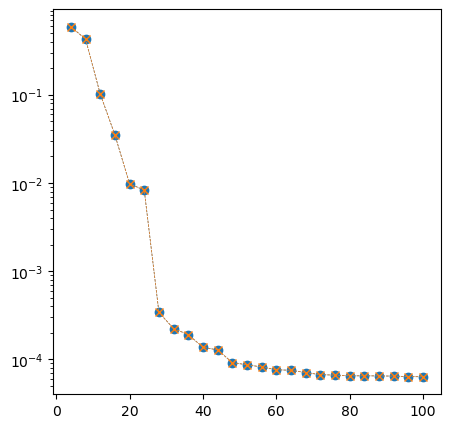

In [23]:
M = csc_matrix(M)
K = csc_matrix(K)

bigMhat = UU.T @ M @ UU
bigKhat = UU.T @ K @ UU

icq       = UU.T @ data[0][:,0]
icqdot    = UU.T @ data[1][:,0]
icqdotdot = UU.T @ data[2][:,0]

bigMhatMC = UUmc.T @ M @ UUmc
bigKhatMC = UUmc.T @ K @ UUmc

icqMC       = UUmc.T @ data[0][:,0]
icqdotMC    = UUmc.T @ data[1][:,0]
icqdotdotMC = UUmc.T @ data[2][:,0]

nList = [4*(i+1) for i in range(25)]
eIntG = np.zeros((len(nList)))
eIntGMC = np.zeros(len(nList))

fig, ax = plt.subplots(1, 1, figsize=(5,5))

for i,n in enumerate(nList):
    pfuncn = lambda t: np.zeros(n)
    Mhat = bigMhat[:n,:n]
    Khat = bigKhat[:n,:n]
    ics  = (icq[:n], icqdot[:n], icqdotdot[:n])
    recon_n  = ru.integrate_LFOM(tTrain, ics, Mhat, np.zeros_like(Mhat),
                                 Khat, pfuncn)
    qrecon = UU[:,:n] @ recon_n[0]
    eIntG[i] = ru.relError(data[0], qrecon)

print(f'the relative L2 errors for intrusive GROM are {eIntG}')

for i,n in enumerate(nList):
    temp = -UUmc[:,:n].T @ K @ data[0][:,0]
    pfuncn = lambda t: temp
    Mhat = bigMhatMC[:n,:n]
    Khat = bigKhatMC[:n,:n]
    ics  = (icqMC[:n], icqdotMC[:n], icqdotdotMC[:n])
    recon_n  = ru.integrate_LFOM(tTrain, ics, Mhat, np.zeros_like(Mhat),
                                 Khat, pfuncn)
    qreconMC = data[0][:,0].reshape(-1,1) + UUmc[:,:n] @ recon_n[0]
    eIntGMC[i] = ru.relError(data[0],qreconMC)

print(f'the relative L2 errors for intrusive GROM (mean centering) are {eIntGMC}')
ax.semilogy(nList, eIntG, label='Intrusive G-ROM', marker='o',
                         linestyle='--', linewidth=0.5, markersize=6)
ax.semilogy(nList, eIntGMC, label='Intrusive G-ROM (MC)', marker='x',
                         linestyle='--', linewidth=0.5, markersize=6)


the relative L2 errors for intrusive GROM are [4.10956285e-02 2.63348325e-02 1.76423092e-02 7.09676551e-03
 4.64013665e-03 1.10021457e-03 2.25955264e-05 2.72100991e-11
 1.27828306e-11 1.25856851e-11 1.25879649e-11 1.25873059e-11
 1.25879253e-11 1.25876874e-11 1.25873541e-11 1.25881787e-11
 1.25877846e-11 1.25867236e-11 1.25875332e-11 1.25865757e-11
 1.25894349e-11 1.25876302e-11 1.25871807e-11 1.25866897e-11
 1.25879934e-11]
the relative L2 errors for intrusive GROM (mean centering) are [5.91944010e-01 4.29466055e-01 1.02423705e-01 3.51419135e-02
 9.81720560e-03 8.28902930e-03 3.40354773e-04 2.23059153e-04
 1.90757543e-04 1.36930055e-04 1.27870381e-04 9.18529996e-05
 8.66140465e-05 8.19435413e-05 7.61501767e-05 7.51042518e-05
 7.06689035e-05 6.69495732e-05 6.61929564e-05 6.49004641e-05
 6.49999213e-05 6.47798774e-05 6.45207579e-05 6.36639877e-05
 6.33683738e-05]


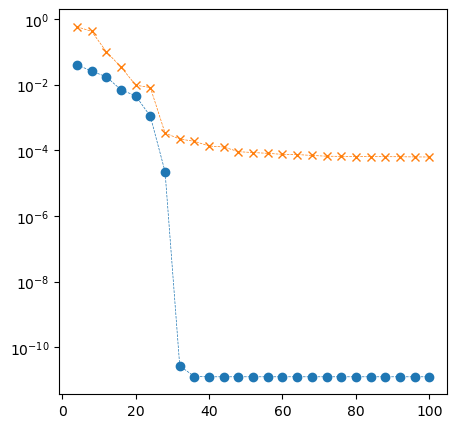

In [31]:
from scipy.sparse import csc_matrix, identity,
from scipy.sparse.linalg import factorized

# Function to collect snapshots of Linear FOM using implicit midpoint method
# L is SS mtx, A is mtx rep. of grad H
def integrate_Lagrange_HROM(tRange, ic, J, A, U):
    two_n  = J.shape[0]
    Nt = tRange.shape[0]
    dt = tRange[1] - tRange[0]

    # Store L @ A as sparse mtx
    JA = csc_matrix(J @ A)

    # Initialize solution array
    xHat       = np.zeros((two_n, Nt))
    xHat[:,0]  = ic
    LHS        = identity(two_n, format='csc') - dt/2 * JA
    solve      = factorized(LHS)

    # Implicit midpoint method
    for i,t in enumerate(tRange[:-1]):
        rhs          = dt * JA @ xHat[:,i]
        delXi        = solve(rhs)
        xHat[:,i+1]  = xHat[:,i] + delXi

    # Snapshots of gradH and time derivative Xdot
    # gradHdata = A @ xData
    # xDataDot  = FDapprox(xData.T, dt).T
    xHatDot = JA @ xHat
    
    qTilde = U @ xHat[:two_n//2]
    pTilde = U @ xHatDot[:two_n//2]

    # return np.concatenate((qTilde, pTilde), axis=0)
    return qTilde

n = bigMhat.shape[0]
bigMhatInv = np.linalg.inv(bigMhat)
# zz = np.zeros(n,n)
# bigAhat = csc_matrix(np.block([[bigKhat, zz], [zz, bigMhatInv]]))

nList = [4*(i+1) for i in range(25)]
eIntH = np.zeros((len(nList)))

fig, ax = plt.subplots(1, 1, figsize=(5,5))

for i,n in enumerate(nList):
    zz = np.zeros((n,n))
    mhInv = np.linalg.inv(bigMhat[:n,:n])
    # Ahat = csc_matrix(np.block([[bigKhat[:n,:n], zz], [zz, bigMhatInv[:n,:n]]]))
    Ahat = csc_matrix(np.block([[bigKhat[:n,:n], zz], [zz, mhInv]]))
    Jr = csc_matrix(np.block([[zz, np.eye(n)], [-np.eye(n), zz]]))
    ics = np.concatenate((icq[:n], (bigMhat @ icqdot)[:n]), axis=0)
    recon_n  = integrate_Lagrange_HROM(tTrain, ics, Jr, Ahat, UU[:,:n])
    qrecon = recon_n[:icq.shape[0]]
    eIntG[i] = ru.relError(data[0], qrecon)

print(f'the relative L2 errors for intrusive GROM are {eIntG}')
print(f'the relative L2 errors for intrusive GROM (mean centering) are {eIntGMC}')
ax.semilogy(nList, eIntG, label='Intrusive G-ROM', marker='o',
                         linestyle='--', linewidth=0.5, markersize=6)
ax.semilogy(nList, eIntGMC, label='Intrusive G-ROM (MC)', marker='x',
                         linestyle='--', linewidth=0.5, markersize=6)

## Computing the ROMs

Here I compute all of the relevant ROM solutions and plot the errors (predictive case)

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_15724/3767284368.py:102: RuntimeWarning: overflow encountered in matmul
  result[i] = data[:,i].T @ A @ data[:,i]


0 the relative L2 errors for intrusive GROM are [5.67e+02 3.02e+17 2.30e+10 1.69e+00 1.00e+00 1.40e+09 2.66e+10 6.56e+16
 1.43e+24 2.71e-02 3.79e-05 1.00e-08 inf 6.20e+84 inf 3.17e+28 1.72e+23
 4.59e+50 5.56e+23 8.32e+88 1.25e-06 1.45e+17 8.71e+02 9.84e+42 6.56e+04]
0 the relative L2 errors for intrusive HROM are [1.50e+00 1.50e+00 1.50e+00 1.50e+00 1.00e+00 1.28e+00 1.51e+00 1.54e+00
 1.56e+00 1.45e+00 1.53e+00 1.43e+00 1.39e+00 1.43e+00 1.28e+00 1.31e+00
 1.23e+00 1.42e+00 1.43e+00 1.44e+00 1.45e+00 1.49e+00 1.47e+00 1.49e+00
 1.53e+00]
0 the relative L2 errors for generic OpInf are [8.58e+19 4.02e+14 1.51e+22 5.21e+03 inf 5.13e+02 2.75e+05 1.28e+10
 6.55e+01 1.12e-01 1.29e-04 7.89e-07 2.46e+10 9.57e+29 4.13e+34 7.75e+33
 inf 3.14e+35 1.00e+00 3.56e+31 3.78e+146 1.98e+14 1.05e+44 2.50e+32
 6.77e+55]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [1.66e+00 1.74e+00 1.87e+00 1.77e+00 1.00e+00 1.65e+00 1.60e+00 1.63e+00
 1.68e+00 1.63e+00 1.66e+00 1.66e+00 1.69e+00 1.68

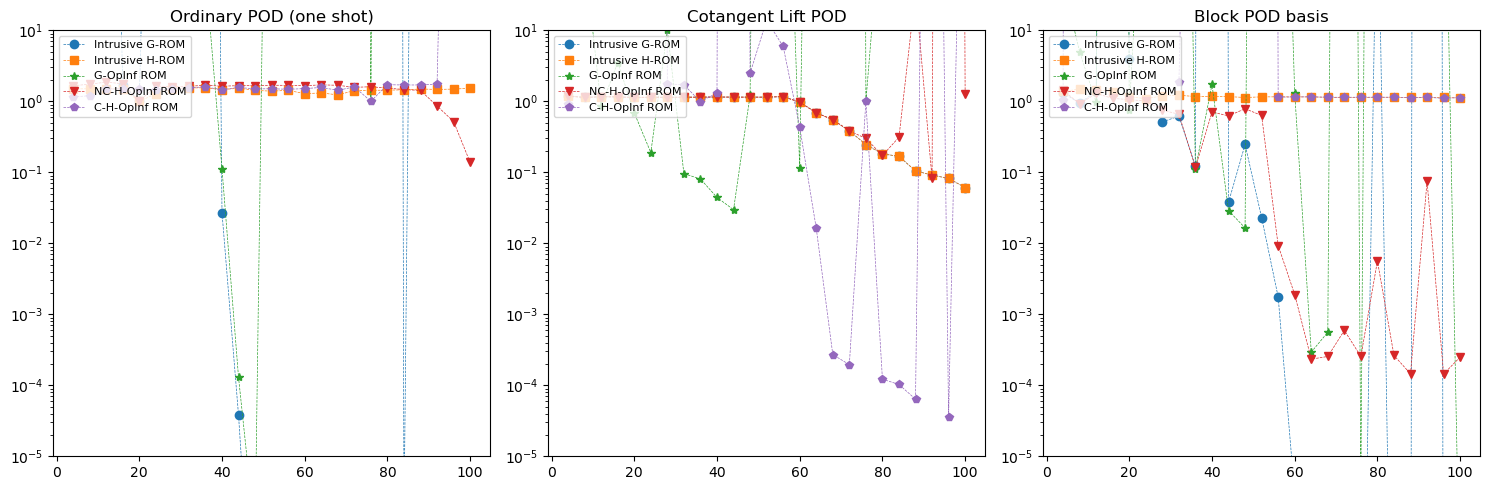

In [41]:
### Exact solution
Ttest     = 1e-1
NtTest    = 201
tTest     = np.linspace(0, Ttest, NtTest)
ic        = data[0][:,0]
# Xac       = X
# Xac = ru.integrate_Linear_HFOM(tTest, ic, Jsp, Asp)[0]
exactE = Hamil(Xac, Asp)

Xd, gH, L, A = xDotData, gradHData, Jsp, Asp

### Parameters
# oneShotList = [True, True, True]
oneShotList = [True, False, False]
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
SigmaList   = [SS, None, None]
MCtog       = [True, True, True]
if any(MCtog):
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]

nList = [4*(i+1) for i in range(25)]
eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5))

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block POD basis']

alpha=1

for i in range(len(UmatList)):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[i], X[:,:Nt], Xd[:,:Nt], 
                                        gH[:,:Nt], L, nList[-1])
    OpLists     = ru.build_Linear_ROM_Ops(UmatList[i], L, A, ic, MC=False)
    OpListOL    = list(OpLists[0])
    
    if MCtog[i]:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[i], X[:,:Nt], Xd[:,:Nt], 
                                           gH[:,:Nt], L, nList[-1], MC=True)
        OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[i], L, A, ic, MC=True)
        OpListMCOL  = list(OpListsMC[0])

    if oneShotList[i]:
        # Compute once and for all
        if MCtog[i]:
            LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-10)
        else:
            LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-10)
        
        AhatOpFull        = ou.C_H_OpInf(OpInfLists[1], nList[-1], SigmaList[i], eps=0.0e-11)

    DhatOpFull            = ou.G_OpInf(OpInfLists[-1], nList[-1], SigmaList[i], eps=0.0e-10)

    for j,n in enumerate(nList):

        if not oneShotList[i]:
            # Compute for each n
            DhatOp  = ou.G_OpInf(OpInfLists[-1], n, SigmaList[i], eps=0.0e-10)
            if MCtog[i]:
                LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-10)
            else:
                LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-10)
            
            AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, SigmaList[i], eps=0.0e-11, BorisZhu=False)
        else:
            if isinstance(UmatList[i], list):
                Ablock1 = AhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Ablock2 = AhatOpFull[idx:idx+n//2,idx:idx+n//2]
                AhatOp  = csc_matrix(np.block([[Ablock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Ablock2]]))

                Dblock1 = DhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Dblock2 = DhatOpFull[idx:idx+n//2,idx:idx+n//2]
                DhatOp  = csc_matrix(np.block([[Dblock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Dblock2]]))
                                              
            else:
                DhatOp  = DhatOpFull[:n,:n]
                AhatOp  = AhatOpFull[:n,:n]

            if MCtog[i]:
                LhatHOpMC = LhatHOpFullMC[:n,:n]
            else:
                LhatHOp   = LhatHOpFull[:n,:n]
        
        if MCtog[i]:
            OpListMCOL[0] = LhatHOpMC
            try:
                XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[1], ic, UmatListMC[i], n, MC=True)
                XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[0], ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
                XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
            except ValueError:
                pass
        else:
            OpListOL[0] = LhatHOp
            try:
                XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[1], ic, UmatList[i], n, MC=False)
                XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[0], ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)
                XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)
            except ValueError:
                pass

        try:
            XrecOp[i,j]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[i])
            XrecOpA[i,j]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[i], L)
        except ValueError:
            pass

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        # HamileIntG[i,j] = np.abs(Hamil(XrecIntG[i,j], Asp) - exactE)
        # HamileIntH[i,j] = np.abs(Hamil(XrecIntH[i,j], Asp) - exactE)
        # HamileOp[i,j]   = np.abs(Hamil(XrecOp[i,j], Asp) - exactE)
        # HamileOpH[i,j]  = np.abs(Hamil(XrecOpH[i,j], Asp) - exactE)
        # HamileOpA[i,j]  = np.abs(Hamil(XrecOpA[i,j], Asp) - exactE)

        HamileIntG[i,j] = Hamil(XrecIntG[i,j], Asp)
        HamileIntH[i,j] = Hamil(XrecIntH[i,j], Asp)
        HamileOp[i,j]   = Hamil(XrecOp[i,j], Asp)
        HamileOpH[i,j]  = Hamil(XrecOpH[i,j], Asp)
        HamileOpA[i,j]  = Hamil(XrecOpA[i,j], Asp)

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-5, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)

plt.tight_layout()
plt.savefig(f'PlatePlotPred', transparent=True)
plt.show()

In [30]:
for i in range(3):
    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i][::3]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i][::3]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i][::3]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i][::3]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i][::3]}' + '\n')

0 the relative L2 errors for intrusive GROM are [5.67e+02 1.69e+00 2.66e+10 2.71e-02 inf 3.17e+28 5.56e+23 1.45e+17
 6.56e+04]
0 the relative L2 errors for intrusive HROM are [1.50e+00 1.50e+00 1.51e+00 1.45e+00 1.39e+00 1.31e+00 1.43e+00 1.49e+00
 1.53e+00]
0 the relative L2 errors for generic OpInf are [8.58e+19 5.21e+03 2.75e+05 1.12e-01 2.46e+10 7.75e+33 1.00e+00 1.98e+14
 6.77e+55]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [1.66e+00 1.77e+00 1.60e+00 1.63e+00 1.69e+00 1.71e+00 1.60e+00 1.42e+00
 1.38e-01]
0 the relative L2 errors for canonical Hamiltonian OpInf are [1.16e+00 1.50e+00 1.49e+00 1.46e+00 1.50e+00 1.57e+00 1.00e+00 1.70e+00
 5.09e+03]

1 the relative L2 errors for intrusive GROM are [1.18e+00 1.15e+00 1.14e+00 1.15e+00 1.15e+00 6.91e-01 2.46e-01 1.05e-01
 6.10e-02]
1 the relative L2 errors for intrusive HROM are [1.18e+00 1.15e+00 1.14e+00 1.15e+00 1.15e+00 6.91e-01 2.46e-01 1.05e-01
 6.10e-02]
1 the relative L2 errors for generic OpInf are [4.83

### Zoomed-in Plot for paper

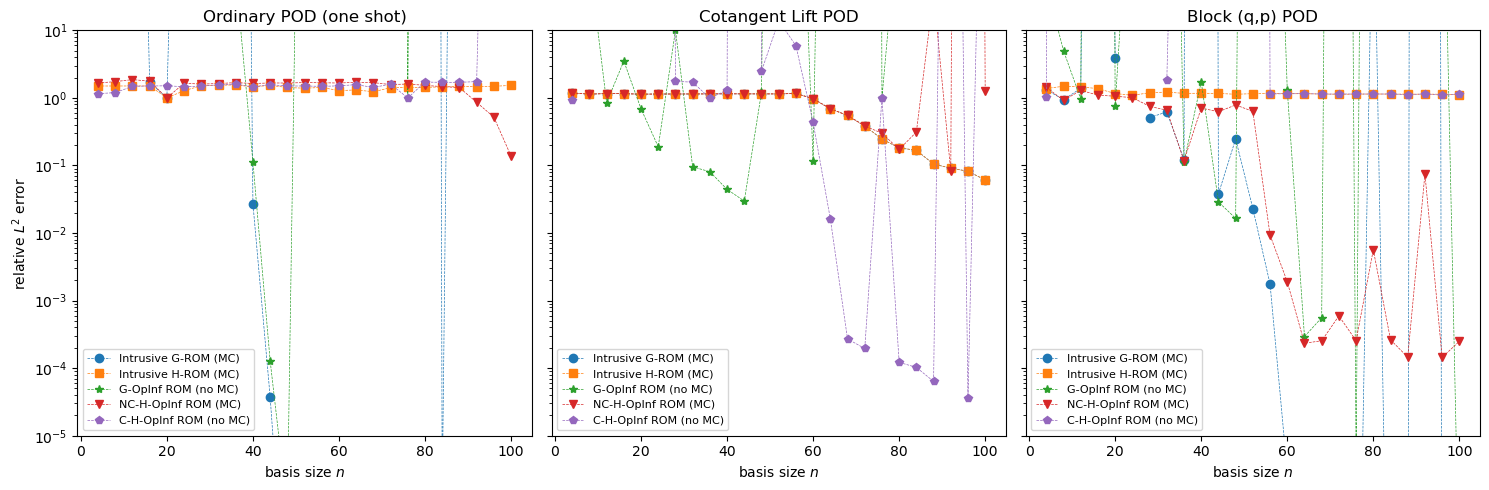

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
                'Block (q,p) POD']

float_formatter = "{:.2e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

alpha=1

for i in range(len(UmatList)):

    # # Print error magnitudes
    # print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    # print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    # print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    # print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    # print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_xlabel('basis size $n$')
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=3)
    ax.flatten()[i].set_ylim([10**-5, 10.])

ax.flatten()[0].set_ylabel(r'relative $L^2$ error')
# ax.flatten()[0].set_ylim([10**-4, 10.])
# ax.flatten()[1].set_ylim([10**-4, 10.])
# ax.flatten()[2].set_ylim([10**-4, 10.])
plt.tight_layout()
# plt.savefig(f'PlatePlotPredZoom', transparent=True)
plt.show()


# fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax.semilogy(nList, eIntG[2], label='Intrusive G-ROM (block (q,p))', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eIntH[1], label='Intrusive H-ROM (cotangent lift)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOp[2],  label='G-OpInf ROM (block (q,p))', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOpH[2], label='NC-H-OpInf ROM (block (q,p))', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOpA[1], label='C-H-OpInf ROM (cotangent lift)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.set_xlabel('basis size $n$')
# ax.set_title('ROM Results')
# ax.legend(prop={'size':8}, loc=3)
# ax.set_ylim([10**-5, 10.])

# ax.set_ylabel(r'relative $L^2$ error')
# # ax.flatten()[0].set_ylim([10**-4, 10.])
# # ax.flatten()[1].set_ylim([10**-4, 10.])
# # ax.flatten()[2].set_ylim([10**-4, 10.])
# plt.tight_layout()
# plt.savefig(f'best_cases_for_Irina', transparent=True)
# plt.show()


### Saving solution data to Exodus file

In [26]:
N = 1764

iList = [2, 1, 2]
jList = [24, 23, 23]

disp_xTest  = Xac[::3][:N]
disp_yTest  = Xac[1::3][:N]
disp_zTest  = Xac[2::3][:N]

for k in range(201):
    exo_copy.put_node_variable_values("exactSol_x", k+1, disp_xTest[:,k])
    exo_copy.put_node_variable_values("exactSol_y", k+1, disp_yTest[:,k])
    exo_copy.put_node_variable_values("exactSol_z", k+1, disp_zTest[:,k])

for l in range(3):
    i = iList[l]
    j = jList[l]

    print(f'num modes is {4*(jList[l]+1)}')
    print(f'errors are' + '\n' + f'{eIntG[i,j]}' + '\n' + f'{eIntH[i,j]}' + '\n' 
          + f'{eOp[i,j]}' + '\n' + f'{eOpH[i,j]}' + '\n' + f'{eOpA[i,j]}' + '\n')

    disp_xRecIntG = XrecIntG[i,j][::3][:N]
    disp_yRecIntG = XrecIntG[i,j][1::3][:N]
    disp_zRecIntG = XrecIntG[i,j][2::3][:N]

    disp_xRecIntH = XrecIntH[i,j][::3][:N]
    disp_yRecIntH = XrecIntH[i,j][1::3][:N]
    disp_zRecIntH = XrecIntH[i,j][2::3][:N]

    disp_xRecOpH = XrecOpH[i,j][::3][:N]
    disp_yRecOpH = XrecOpH[i,j][1::3][:N]
    disp_zRecOpH = XrecOpH[i,j][2::3][:N]

    disp_xRecOpA = XrecOpA[i,j][::3][:N]
    disp_yRecOpA = XrecOpA[i,j][1::3][:N]
    disp_zRecOpA = XrecOpA[i,j][2::3][:N]

    disp_xRecOp  = XrecOp[i,j][::3][:N]
    disp_yRecOp  = XrecOp[i,j][1::3][:N]
    disp_zRecOp  = XrecOp[i,j][2::3][:N]

    for k in range(201):
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_x", k+1, disp_xRecIntG[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_y", k+1, disp_yRecIntG[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_z", k+1, disp_zRecIntG[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_x", k+1, disp_xRecIntH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_y", k+1, disp_yRecIntH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_z", k+1, disp_zRecIntH[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_x", k+1, disp_xRecOpH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_y", k+1, disp_yRecOpH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_z", k+1, disp_zRecOpH[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_x", k+1, disp_xRecOpA[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_y", k+1, disp_yRecOpA[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_z", k+1, disp_zRecOpA[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_x", k+1, disp_xRecOp[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_y", k+1, disp_yRecOp[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_z", k+1, disp_zRecOp[:,k])

num modes is 100
errors are
1.748077673295377e-11
1.1163604734047115
5.9522214172172546e-08
0.00024965120042774307
1.1305922359677751

num modes is 96
errors are
0.08205729880187161
0.08205729880189121
2002798665614.5032
7.582408400838874e+49
3.578297366558623e-05

num modes is 96
errors are
7.0937318799832985e-12
1.1329021094826957
38351.639604315395
0.00014410708377812193
1.0997618871328032



### Plots of Hamiltonian conservation

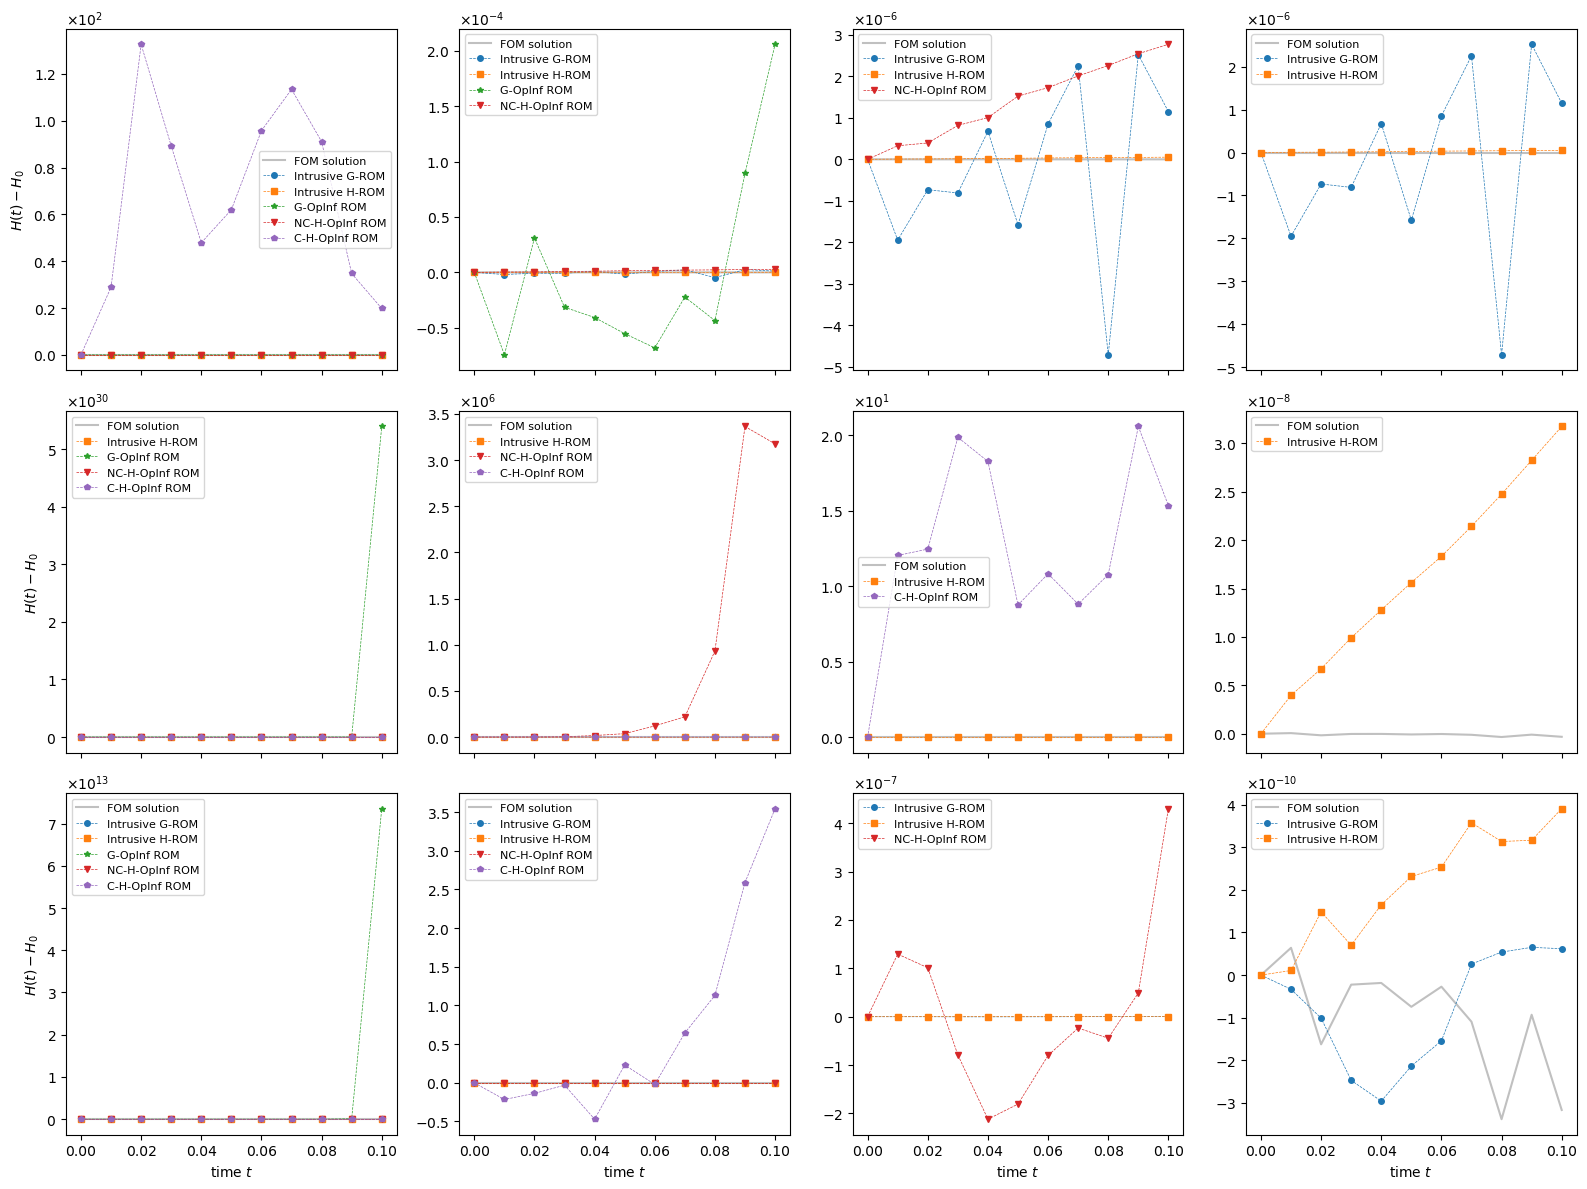

In [8]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(3, 4, figsize=(16,12), sharex=True)

skip=20

titleList   = ['All', 
               'G-OpInf ROM',
               'C-H-OpInf ROM' , 
               'Other H-ROMs']

i,j = 0,11

ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[::skip]-exactE[::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)


i,j = 1,-4

ax.flatten()[4].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[4].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[5].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[6].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[6].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[7].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[7].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[7].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)

i,j = 2,-2

ax.flatten()[8].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[8].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[9].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[9].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[11].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[11].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[11].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)

for i in range(3):
    ax[i,0].set_ylabel(r'$H(t) - H_0$')

for i in range(4):
    ax[-1,i].set_xlabel('time $t$')

for i in range(12):
    # ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
plt.savefig(f'EnergyLinearElastic', transparent=True)
plt.show()


### Experiment testing effect of regularization

0 the relative L2 errors for generic OpInf are [1.40e+00 1.40e+00 1.40e+00 1.40e+00 1.40e+00 1.40e+00 1.40e+00 1.42e+00
 4.87e+03 3.47e+62 2.75e+38 3.79e+01 1.46e+00 1.48e+00]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [1.41e+00 1.41e+00 1.41e+00 1.40e+00 1.40e+00 1.41e+00 1.41e+00 1.41e+00
 1.41e+00 1.41e+00 1.41e+00 1.41e+00 1.40e+00 1.40e+00]
0 the relative L2 errors for canonical Hamiltonian OpInf are [9.09e+101 1.61e+18 4.21e+16 1.01e+30 1.71e+104 1.00e+00 5.10e+90 6.35e+32
 8.26e+07 8.59e+04 3.03e+00 1.54e+00 1.48e+00 1.47e+00]
0 the relative L2 errors for boris/zhu Hamiltonian OpInf are [9.29e+28 9.29e+28 9.29e+28 9.29e+28 9.29e+28 1.00e+00 9.29e+28 9.29e+28
 9.29e+28 9.29e+28 9.29e+28 9.29e+28 9.29e+28 9.29e+28]

1 the relative L2 errors for generic OpInf are [5.02e+116 5.63e+22 4.06e+13 1.76e+44 2.50e+86 8.50e+02 inf 6.31e+32
 4.37e+47 2.37e+63 2.50e+149 1.25e+04 1.46e+00 1.48e+00]
1 the relative L2 errors for noncanonical Hamiltonian OpInf are [1.37e+00 1

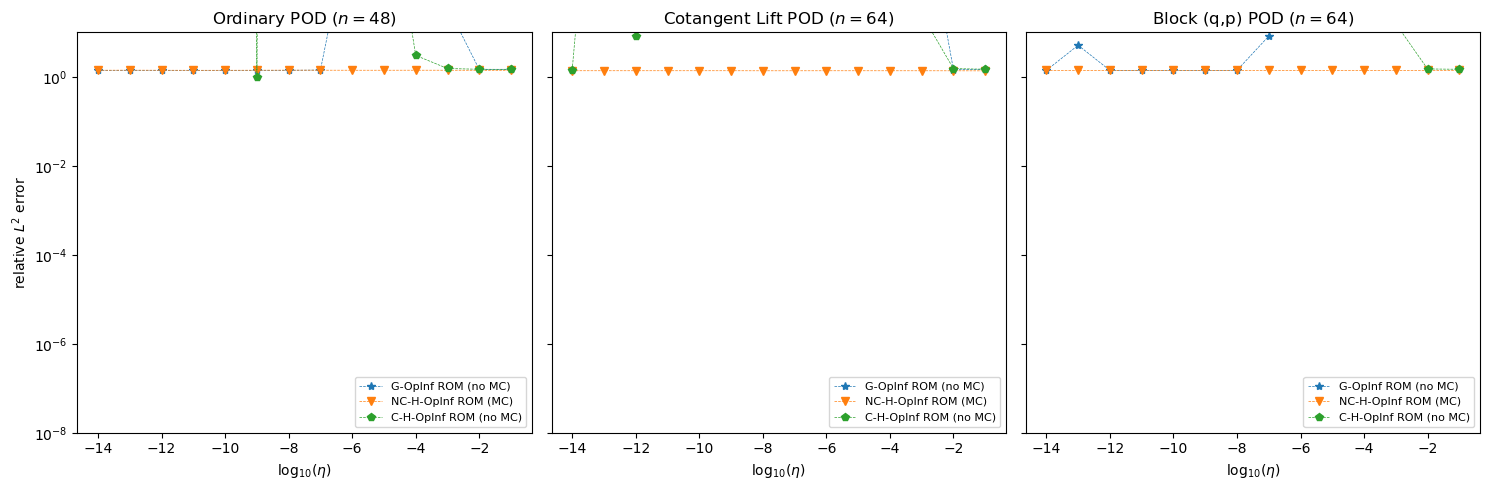

In [9]:
from importlib import reload
reload(ou)

### Exact solution
Ttest     = 1e-1
NtTest    = 201
tTest     = np.linspace(0, Ttest, NtTest)
ic        = data[0][:,0]
Xac       = X
# Xac = ru.integrate_Linear_HFOM(tTest, ic, Jsp, Asp)[0]
# exactE = Hamil(Xac, Asp)

Xd, gH, L, A = xDotData, gradHData, Jsp, Asp

### Parameters
oneShot = False
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
# UmatList    = [UU]
MCtog       = True
if MCtog:
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]
    # UmatListMC = [[UUqmc, UUpmc]]
    # UmatListMC = [UUmc]


nList = [4*(11+1), 4*(15+1), 4*(15+1)]
regList=[10**i for i in range(14)]

eOpH   = np.zeros((3, 14))
eOp    = np.zeros((3, 14))
eOpA   = np.zeros((3, 14))
eOpAbz   = np.zeros((3, 14))

# HamileIntG = np.zeros((3, len(nList), NtTest))
# HamileIntH = np.zeros((3, len(nList), NtTest))
# HamileOpH  = np.zeros((3, len(nList), NtTest))
# HamileOp   = np.zeros((3, len(nList), NtTest))
# HamileOpA  = np.zeros((3, len(nList), NtTest))

# XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
# XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((14, 2*Nover2, NtTest))
XrecOpH  = np.zeros((14, 2*Nover2, NtTest))
XrecOpA  = np.zeros((14, 2*Nover2, NtTest))
XrecOpAbz  = np.zeros((14, 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

titleList   = ['Ordinary POD ($n=48$)', 
               'Cotangent Lift POD ($n=64$)',
               'Block (q,p) POD ($n=64$)']

alpha=1

for l,n in enumerate(nList):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[l], X[:,:Nt], Xd[:,:Nt], 
                                        gH[:,:Nt], L, n)
    OpLists     = ru.build_Linear_ROM_Ops(UmatList[l], L, A, ic, MC=False)
    OpListOL    = list(OpLists[0])

    if MCtog:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[l], X[:,:Nt], Xd[:,:Nt], 
                                            gH[:,:Nt], L, n, MC=True)
        OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[l], L, A, ic, MC=True)
        OpListMCOL  = list(OpListsMC[0])

    for i, reg in enumerate(regList):

        DhatOpFull            = ou.G_OpInf(OpInfLists[-1], n, None, eps=1.0e-7*reg)

        if not oneShot:
            # Compute for each n
            DhatOp  = ou.G_OpInf(OpInfLists[-1], n, None, eps=1.0e-7*reg)
            if MCtog:
                LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=1.0e-7*reg)
            else:
                LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=1.0e-7*reg)
            
            AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, None, eps=1.0e-7*reg, BorisZhu=False)
            AhatOpbz      = ou.C_H_OpInf(OpInfLists[1], n, None, eps=1.0e-7*reg, BorisZhu=True)
        
        if MCtog:
            OpListMCOL[0] = LhatHOpMC
            try:
                XrecOpH[i]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[l],
                                                    n, MC=True, Hamiltonian=True)
            except ValueError:
                pass
        else:
            OpListOL[0] = LhatHOp
            try:
                XrecOpH[i]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[l],
                                                    n, MC=False, Hamiltonian=True)
            except ValueError:
                pass

        try:
            XrecOp[i]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[l])
            XrecOpA[i]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[l], L)
            XrecOpAbz[i]  = ru.integrate_OpInf_ROM(tTest, AhatOpbz, ic, UmatList[l], L)
        except ValueError:
            pass

        eOp[l,i]   = ru.relError(Xac, XrecOp[i])
        eOpH[l,i]  = ru.relError(Xac, XrecOpH[i])
        eOpA[l,i]  = ru.relError(Xac, XrecOpA[i])
        eOpAbz[l,i]  = ru.relError(Xac, XrecOpAbz[i])
    
    # Print error magnitudes
    print(f'{l} the relative L2 errors for generic OpInf are {eOp[l]}')
    print(f'{l} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[l]}')
    print(f'{l} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[l]}')
    print(f'{l} the relative L2 errors for boris/zhu Hamiltonian OpInf are {eOpAbz[l]}' + '\n')

    
    listo = [-(14-j) for j in range(14)]
    ax.flatten()[l].semilogy(listo, eOp[l],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[l].semilogy(listo, eOpH[l], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[l].semilogy(listo, eOpA[l], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    # if l==1:
    #     ax.flatten()[1].semilogy(listo, eOpAbz[l], label='H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[l].set_xlabel(r'$\log_{10}(\eta)$')
    ax.flatten()[l].set_title(f'{titleList[l]}')
    ax.flatten()[l].legend(prop={'size':8}, loc=4)
    ax.flatten()[l].set_ylim([10**-8, 10.])

ax.flatten()[0].set_ylabel(r'relative $L^2$ error')

plt.tight_layout()
# plt.savefig(f'PlatePlotReg', transparent=True)
plt.show()

# 16 - pqblock
# 24 - cotlift
# 12 - ord


In [27]:
exo_copy.close()

Closing exodus file: beam_vecIC_100_written.e
